# ライブラリの読み込みと設定

In [1]:
# Google Collaboratory で MeCab を使うためにインストールするもの
# !apt install -y mecab libmecab-dev mecab-ipadic-utf8
# !pip install mecab-python3

In [2]:
# Pythonライブラリのロード
from __future__ import annotations
from typing import List, Dict, Optional
import os
import subprocess
import re
import json
import numpy as np
import pandas as pd
from collections import defaultdict
from datetime import datetime
from glob import glob
from tqdm import tqdm
from neologdn import normalize as neonorm
from MeCab import Tagger
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 基本となるフォルダ名
BASE_FOLDER: str = '.'
# Livedoor ニュースコーパスがあるフォルダ名
LIVEDOOR_NEWS_CORPUS_FOLDER: str = f'{BASE_FOLDER}/livedoor_news_corpus'
# Livedoor ニュースコーパスを処理したアウトプット
LIVEDOOR_NEWS_CORPUS_OUTPUT: str = f'{LIVEDOOR_NEWS_CORPUS_FOLDER}/news.jsonl'

# MeCab を使った形態素解析

In [4]:
class Tokenizer:
    # MeCab 辞書として、IPA辞書・JUMAN辞書・IPA NEologd辞書の３種類に対応
    INSTALLED_DICTIONARIES: List[str] = ['ipa', 'juman', 'neologd']

    def __init__(
        self: Tokenizer,
        dictionary: Optional[str] = None
    ) -> None:
        if dictionary is not None:
            self.dictionary = dictionary
        else:
            # 設定が無い場合はIPA辞書を用いる
            self.dictionary = 'ipa'
        self._load_mecab()
        return

    def _load_mecab(self: Tokenizer) -> None:
        '''MeCab辞書のパスや設定ファイルの場所を特定して、
        形態素解析を行うTaggerをロードする
        '''
        if os.path.isdir(self.dictionary):
            # load local dictionary
            print(f'loading local dictionary: {self.dictionary}')
            self.tagger = Tagger(f'-d {self.dictionary}')
            return
        elif self.dictionary not in self.INSTALLED_DICTIONARIES:
            raise ValueError(f'dictionary not found: {self.dictionary}')
        # load installed dictionary
        mecab_config_path = None
        # retrive the directory of dictionary
        mecab_config_cands = [
            '/usr/bin/mecab-config', '/usr/local/bin/mecab-config'
        ]
        for c in mecab_config_cands:
            if os.path.exists(c):
                mecab_config_path = c
                break
        if mecab_config_path is None:
            raise SystemError(
                'mecab-config not found. check mecab is really installed'
            )
        dic_dir = subprocess.run(
            [mecab_config_path, '--dicdir'],
            check=True, stdout=subprocess.PIPE, text=True
        ).stdout.rstrip()
        # retrive the dictonary
        dic_path = None
        if self.dictionary == 'ipa':
            dic_cands = ['ipadic-utf8', 'ipadic']
        elif self.dictionary == 'juman':
            dic_cands = ['juman-utf8', 'jumandic']
        else:  # self.dictionary == 'neologd'
            dic_cands = ['mecab-ipadic-neologd']
        for c in dic_cands:
            tmpdir = os.path.join(dic_dir, c)
            if os.path.isdir(tmpdir):
                dic_path = tmpdir
                break
        if dic_path is None:
            raise SystemError(
                f'installed dictionary not found: {self.dictionary}'
            )
        # create tagger
        print(f'loading installed dictionary: {self.dictionary}')
        self.tagger = Tagger(f'-d {dic_path}')
        return

    def test_tokenize(self: Tokenizer, sentence: str) -> None:
        '''形態素解析した結果をそのまま表示する

        Args:
            sentence (str): 形態素解析したい文章
        '''
        # 文章の長さが 0 だったら、空のリストを返す
        if len(sentence) == 0:
            return []
        # 形態素解析して、出力を行毎に分割した配列にする
        nodes = self.tagger.parse(sentence).splitlines()
        for node in nodes:
            print(node)
        return

    def tokenize(self: Tokenizer, sentence: str) -> List[str]:
        '''形態素解析（文章を単語に切る）を行う

        Args:
            sentence (str): 解析したい（単語に切り分けたい）文章

        Returns
            List[str]: 単語のリスト
        '''
        # 文章の長さが 0 だったら、空のリストを返す
        if len(sentence) == 0:
            return []
        # 単語のリストを保存する変数
        words = list()
        # 形態素解析して、出力を行毎に分割した配列にする
        nodes = self.tagger.parse(sentence).splitlines()
        for node in nodes:
            node = node.strip()
            # 文章の終了（EOS: End Of Sentence）だったら終了
            if node == 'EOS':
                break
            # 表層型（文章に出てくる形）と単語の特徴に分解
            surface, feature_str = node.strip().split('\t', 1)
            # 特徴をリストに変換
            features = feature_str.split(',')
            # 有効な単語だったら単語のリストに加える
            if self._is_valid_word(surface=surface, features=features) is True:
                words.append(
                    self._get_word(surface=surface, features=features)
                )
        # 単語のリストを返す
        return words

    def _is_valid_word(
        self: Tokenizer,
        surface: str,
        features: List[str]
    ) -> bool:
        '''有効な単語かどうか判定する
        ここでは最も基本として、すべての単語を有効とする

        Args:
            surface (str): 単語の表層型（文章に出てくる形）
            features (List[str]): 単語の特徴のリスト

        Returns:
            bool: 有効な単語だったら True, 無効な単語だったら False
        '''
        return True

    def _get_word(
        self: Tokenizer,
        surface: str,
        features: List[str]
    ) -> str:
        '''利用したい単語を返す
        ここでは最も基本として、表層型をそのまま返す
        Args:
            surface (str): 単語の表層型（文章に出てくる形）
            features (List[str]): 単語の特徴のリスト

        Returns:
            str: 利用したい単語
        '''
        return surface

In [5]:
tokenizer = Tokenizer()
# MeCabの出力をそのまま表示してみる
# フォーマットは以下のURLを参照
# https://taku910.github.io/mecab/#parse
tokenizer.test_tokenize('吾輩は猫である。名前はまだ無い。')

loading installed dictionary: ipa
吾輩	名詞,代名詞,一般,*,*,*,吾輩,ワガハイ,ワガハイ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
猫	名詞,一般,*,*,*,*,猫,ネコ,ネコ
で	助動詞,*,*,*,特殊・ダ,連用形,だ,デ,デ
ある	助動詞,*,*,*,五段・ラ行アル,基本形,ある,アル,アル
。	記号,句点,*,*,*,*,。,。,。
名前	名詞,一般,*,*,*,*,名前,ナマエ,ナマエ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
まだ	副詞,助詞類接続,*,*,*,*,まだ,マダ,マダ
無い	形容詞,自立,*,*,形容詞・アウオ段,基本形,無い,ナイ,ナイ
。	記号,句点,*,*,*,*,。,。,。
EOS


# FastText を使った単語分散表現

* FastText を使うにはまず大量のテキストを学習しなければならない
* 今回は私がすでに学習したものを用いる
    * https://github.com/tetutaro/fasttext_binary_jawiki
* 日本語 Wikipedia を FastText で学習し、それを Word2Vec 形式に変換したもの

In [6]:
class Vectorizer:
    def __init__(self: Vectorizer) -> None:
        self.kvs = self._load_kvs()
        return

    def _load_kvs(self: Vectorizer) -> KeyedVectors:
        '''Word2Vec形式のバイナリをロードする
        '''
        # バイナリのパス
        bin_fn = 'kv_fasttext_jawiki.bin'
        return KeyedVectors.load_word2vec_format(bin_fn, binary=True)

    def is_exists(self: Vectorizer, word: str) -> bool:
        '''その単語が学習済みの単語かをチェックする

        Args:
            word (str): 単語

        Return:
            bool: 学習済みであれば True
        '''
        try:
            _ = self.kvs.get_vector(word)
        except Exception:
            return False
        return True

    def get_vector(self: Vectorizer, word: str) -> np.ndarray:
        '''単語の分散表現（ベクトル）を返す

        Args:
            word (str): 単語

        Returns:
            np.ndarray: 単語ベクトル
        '''
        return self.kvs.get_vector(word)

    def find_similar(
        self: Vectorizer,
        pos: str,
        neg: Optional[str] = None,
        topn: Optional[int] = 5
    ) -> None:
        '''意味が近い単語を探して表示する

        Args:
            pos (str): 足し算する単語（カンマ区切り）
            neg (str): 引き算する単語（カンマ区切り）
            topn (int): 表示する TOP N 個（デフォルト:5）
        '''
        positives = list()
        pos = neonorm(pos).split(',')
        for p in pos:
            p = p.strip()
            try:
                _ = self.kvs.get_vector(p)
            except Exception:
                print(f'「{p}」は学習済みの語彙にありません')
            else:
                positives.append(p)
        if len(positives) == 0:
            raise ValueError('no positive word')
        negatives = list()
        if neg is not None and len(neg) > 0:
            neg = neonorm(neg).split(',')
            for n in neg:
                n = n.strip()
                try:
                    _ = self.kvs.get_vector(n)
                except Exception:
                    print(f'「{n}」は学習済みの語彙にありません')
                else:
                    negatives.append(p)
            if len(negatives) == 0:
                negatives = None
        rets = self.kvs.most_similar(
            positive=positives, negative=negatives, topn=topn
        )
        print('【結果】')
        for i, ret in enumerate(rets):
            print(f'{i + 1}. {ret[0]} : {ret[1]}')
        return

In [7]:
vectorizer = Vectorizer()

In [8]:
# フロンターレに近い意味の単語
vectorizer.find_similar(pos='フロンターレ')

【結果】
1. 川崎フロンターレ : 0.7913177609443665
2. 大宮アルディージャ : 0.7143867015838623
3. 浦和レッドダイヤモンズ : 0.6895752549171448
4. モンテディオ山形 : 0.6875848770141602
5. 浦和レッズ : 0.6856690049171448


In [9]:
# 水泳＋自転車＋マラソン に近い意味の単語
vectorizer.find_similar(pos='水泳,自転車,マラソン')

【結果】
1. トライアスロン : 0.7370837330818176
2. オープンウォータースイミング : 0.703038215637207
3. 陸上競技 : 0.6951232552528381
4. サイクリング : 0.6843615770339966
5. 車いすマラソン : 0.6829684972763062


In [10]:
# 王−男＋女 に近い意味の単語
vectorizer.find_similar(pos='王,女', neg='男')

【結果】
1. 王位 : 0.6800739169120789
2. 国王 : 0.6587194204330444
3. 王妃 : 0.645143985748291
4. 王師 : 0.6246190667152405
5. 王家 : 0.6205375790596008


In [11]:
# 右腕−右＋左 に近い意味の単語
vectorizer.find_similar(pos='右腕,左', neg='右')

【結果】
1. 左腕 : 0.794193685054779
2. 片腕 : 0.659541666507721
3. 腕 : 0.6463324427604675
4. 左肩 : 0.6120174527168274
5. 肩 : 0.5933518409729004


In [12]:
# 札幌−東京＋大阪 に近い意味の単語
# ＝北海道における東京は札幌だとすれば、北海道における大阪はどこ？
vectorizer.find_similar(pos='札幌,大阪', neg='東京')

【結果】
1. 函館 : 0.7657108902931213
2. 帯広 : 0.7308138012886047
3. 札幌市 : 0.7134404182434082
4. 旭川 : 0.7041326761245728
5. 小樽 : 0.6998960375785828


# livedoorニュースの記事をベクトル化する

* このプログラムを組む前に、実際にニュースのテキストファイルを読み、以下の規則性を発見したものとする
    * １行目は記事の URL
    * ２行目は記事が掲載された時刻
    * ３行目は記事のタイトル
* 各フォルダには "LICENSE.txt" というファイルが有り、これは記事ではなくライセンスの説明である

In [13]:
class CorpusReader:
    def __init__(
        self: CorpusReader,
        dictionary: Optional[str] = None
    ) -> None:
        self.documents = dict()
        self.tokenizer = Tokenizer(dictionary=dictionary)
        self._read_files()
        return

    def _read_files(self: CorpusReader) -> None:
        '''特定のフォルダ下にあるファイルを全部読んで
        それを保持する
        '''
        for fname in tqdm(glob(f'{LIVEDOOR_NEWS_CORPUS_FOLDER}/*/*.txt')):
            # ファイルを読んでニュースの情報を得る
            news = self._read_file(fname=fname)
            if len(news) == 0:
                continue
            self.documents[news['document_id']] = news
        return

    def _read_file(self: CorpusReader, fname: str) -> Dict[str, str]:
        '''ニュースのファイルを読んで、その情報を辞書形式に変換する

        Args:
            fname (str): ファイルのパス名

        Returns:
            Dict[str, str]: ニュースの情報を辞書形式にしたもの
        '''
        # ファイルのパス名をフォルダ毎に区切ってバラバラにする
        paths = fname.strip().split(os.sep)
        # 一番深いフォルダ名（雑誌名）をカテゴリ名として取得
        category = paths[-2]
        # 記事IDとして、ファイル名をハイフンで区切った最後の数字を取得
        document_id = os.path.splitext(paths[-1])[0].split('-')[-1]
        # LICENSE.txt だったら空の情報を返す
        if document_id == 'LICENSE':
            return {}
        # ファイルの中身を読み込む
        with open(fname, 'rt') as rf:
            # ファイルを読む
            buffer = rf.read()
            # 行ごとに区切った配列にする
            lines = buffer.splitlines()
        # 記事の内容をいれておく変数
        contents = list()
        # 単語をいれておく変数
        words = list()
        # あらかじめファイルの中身を確認し、
        # 行番号に対する規則性を見つける。
        # そしてその情報を得る
        for i, line in enumerate(lines):
            line = line.strip()
            if i == 0:
                # 記事URL
                url = line
            elif i == 1:
                # 記事掲載時刻（時刻のフォーマットも確認しておく）
                created_at = datetime.strptime(line, '%Y-%m-%dT%H:%M:%S%z')
            elif i == 2:
                # 記事タイトル
                title = line
            elif self._is_invalid_line(line=line):
                # この行の取り込みをやめる
                continue
            elif len(line) > 0:
                # 文章を正規化する
                line = neonorm(line)
                # コンテンツとして文章を追加する
                contents.append(neonorm(line))
                # 文章を単語に分け、追加する
                words.extend(self.tokenizer.tokenize(sentence=line))
            else:
                # 空行は読み飛ばす
                continue
        return {
            'document_id': document_id,
            'category': category,
            'url': url,
            'created_at': created_at.strftime('%Y/%m/%d %H:%M:%S'),
            'title': title,
            'contents': '\n'.join(contents),
            'words': words,
        }

    def _is_invalid_line(self: CorpusReader, line: str) -> bool:
        '''その行を内容から外す

        Args:
            line (str): 行の文字列

        Returns:
            bool: その行を内容から外す場合は True
        '''
        return False

    def count_words(self: CorpusReader) -> None:
        '''全部のニュースから単語数を計算して表示する
        '''
        # カウント
        word_counter = defaultdict(int)
        for did, document in self.documents.items():
            for word in document['words']:
                word_counter[word] += 1
        print('単語が出てくる回数が多い順に表示')
        for i, (key, val) in enumerate(sorted(
            word_counter.items(), key=lambda x: x[1], reverse=True
        )):
            print(f'{i + 1}: {key}: {val}')
            if i > 28:
                break
        return

In [14]:
corpus_reader = CorpusReader()

loading installed dictionary: ipa


100%|██████████████████████████████████████| 7376/7376 [00:22<00:00, 327.22it/s]


In [15]:
corpus_reader.count_words()

単語が出てくる回数が多い順に表示
1: 、: 202029
2: の: 200743
3: 。: 133588
4: に: 128032
5: を: 123424
6: が: 113258
7: は: 110185
8: て: 100550
9: で: 82632
10: た: 82547
11: と: 75405
12: し: 61716
13: 「: 57973
14: 」: 53492
15: も: 46970
16: ・: 40752
17: な: 35334
18: (: 32260
19: いる: 26761
20: する: 26742
21: ): 26267
22: ない: 25368
23: こと: 24466
24: ます: 23522
25: さ: 22470
26: だ: 21711
27: です: 21611
28: から: 21437
29: れ: 19717
30: い: 17806


## 自然言語処理の前処理

* 何も考えずに処理を行うと、出現回数が多い単語は、ほぼ意味が分からない
    * 接続詞・助詞が多い
    * 句読点などの記号も多い
* これらを除外して、いかにテキストから意味のある単語のみを抽出する
    * 「前処理」
* この「前処理」が、機械学習モデルを作る上で一番大変
    * 何回もやり直して、満足するまで繰り返す
    * しかし、やればやるだけ精度があがっていく

In [16]:
class Tokenizer2(Tokenizer):
    '''Tokenizerを継承し、前処理を加えたクラス
    '''
    # 日本語の多くの文章に用いられるため、
    # その単語を使うと文章の意味が似通ってしまい、意味の違いがとれなくなる単語
    stop_words: List[str] = [
        'する', 'いる', 'れる', 'こと', 'なる', 'ある', 'できる',
        'よう', 'さん', '思う', 'ない', 'られる', 'いう', 'くる',
        'みる', 'ため', 'もの', 'しまう', '言う', 'いく', 'これ',
        '人', '月', '年', '歳', '中', '日', 'いい', 'そう', '一',
        '的', '記事', '見る', '円', '関連', '者', '時', '何', '今',
        '今回', '方', 'くれる', 'たち', '私', '自分', '万', '行う',
        'それ', '場合', '上', '気', '名', '氏', '前', '本', '彼',
        '後', 'くださる', 'とき', 'ところ', 'おる', '知る', 'やる',
        '化', '数', '作', '目', '位', '行く', '回', '以上', '会',
        '店', '分', '度', '感', '版', 'しれる', 'わかる', 'てる',
    ]

    def __init__(
        self: Tokenizer2,
        dictionary: Optional[str] = None
    ) -> None:
        super().__init__(dictionary=dictionary)
        self.vectorizer = Vectorizer()
        return

    def _is_valid_word(
        self: Tokenizer,
        surface: str,
        features: List[str]
    ) -> bool:
        '''有効な単語かどうか判定する

        Args:
            surface (str): 単語の表層型（文章に出てくる形）
            features (List[str]): 単語の特徴のリスト

        Returns:
            bool: 有効な単語だったら True, 無効な単語だったら False
        '''
        # 名詞・動詞・形容詞じゃなかったら除外
        # https://www.unixuser.org/~euske/doc/postag/
        if features[0] not in ['名詞', '動詞', '形容詞']:
            return False
        # UNK(Unknown: 未知語）だったら除外
        if len(features) < 8:
            return False
        # ひらがなカタカナ一文字だったら除外
        if re.match(r'^[あ-んア-ン]$', surface) is not None:
            return False
        # 数字から始まる単語だったら除外
        if re.match(r'^[0-9].*$', surface) is not None:
            return False
        # マイナスから始まる単語だったら除外
        if re.match(r'^\-.*$', surface) is not None:
            return False
        word = self._get_word(surface=surface, features=features)
        # stop word だったら除外
        if word in self.stop_words:
            return False
        # FastText で学習済みでなかったら除外
        return self.vectorizer.is_exists(word=word)

    def _get_word(
        self: Tokenizer,
        surface: str,
        features: List[str]
    ) -> str:
        '''利用したい単語を返す

        Args:
            surface (str): 単語の表層型（文章に出てくる形）
            features (List[str]): 単語の特徴のリスト

        Returns:
            str: 利用したい単語
        '''
        # 原型を返す
        # IPA もしくは IPA NEologd 辞書の場合 features[6] に入っているが
        # JUMAN 辞書の場合には features[4] に入っている
        return features[6]

In [17]:
class CorpusReader2(CorpusReader):
    def __init__(
        self: CorpusReader2,
        dictionary: Optional[str] = None
    ) -> None:
        self.documents = dict()
        self.vectors = dict()
        self.tokenizer = Tokenizer2(dictionary=dictionary)
        self._read_files()
        return

    def _is_invalid_line(self: CorpusReader2, line: str) -> bool:
        '''その行を内容から外す

        Args:
            line (str): 行の文字列

        Returns:
            bool: その行を内容から外す場合は True
        '''
        # URL だけが書いてある行は内容から外す
        if re.match(r'^http', line) is not None:
            return True
        return False

    def calc_vectors(self: CorpusReader2) -> None:
        '''ドキュメントからベクトルを計算する
        '''
        for did, doc in tqdm(self.documents.items()):
            # 有効な単語のリスト
            words = doc['words']
            if len(words) == 0:
                continue
            # ベースとなる300次元のベクトル
            vec = np.zeros(300)
            # 単語毎にベクトルを足していく
            for word in words:
                # 単語のベクトルを取得
                tvec = self.tokenizer.vectorizer.get_vector(word=word).copy()
                # ベクトルを正規化
                tvec /= np.linalg.norm(tvec, ord=2)
                # 累積
                vec += tvec
            vec /= len(words)
            self.vectors[did] = vec
        return

    def visualize_vectors(self: CorpusReader2) -> None:
        '''計算したベクトルを可視化する
        '''
        dids = list()
        vecs = list()
        labels = list()
        for did, vec in sorted(self.vectors.items()):
            dids.append(vec)
            vecs.append(vec)
            labels.append(self.documents[did]['category'])
        vecs = np.array(vecs)
        tsne = TSNE(
            n_components=2, random_state=12,
            init='pca', learning_rate='auto'
        )
        plane = tsne.fit_transform(vecs)
        df = pd.DataFrame({
            'x1': plane[:, 0],
            'x2': plane[:, 1],
            'label': labels,
        })
        uniq_labels = sorted(list(set(labels)))
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        for i, label in enumerate(uniq_labels):
            tmpdf = df.loc[df['label'] == label, ['x1', 'x2']]
            ax = tmpdf.plot(
                kind='scatter', x='x1', y='x2', label=label, ax=ax,
                color=sns.color_palette('husl', len(uniq_labels) + 1)[i]
            )
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
        return

    def save(self: CorpusReader2) -> None:
        '''処理や計算したものをアウトプットする
        '''
        with open(LIVEDOOR_NEWS_CORPUS_OUTPUT, 'wt') as wf:
            for did, vec in tqdm(sorted(self.vectors.items())):
                doc = self.documents[did]
                info = {
                    'id': did,
                    'category': doc['category'],
                    'url': doc['url'],
                    'created_at': doc['created_at'],
                    'title': doc['title'],
                    'contents': doc['contents'],
                    'vector': [float(x) for x in list(vec)],
                }
                wf.write(json.dumps(info, ensure_ascii=False) + '\n')
        return

In [18]:
corpus_reader = CorpusReader2()

loading installed dictionary: ipa


100%|██████████████████████████████████████| 7376/7376 [00:38<00:00, 191.45it/s]


In [19]:
corpus_reader.count_words()

単語が出てくる回数が多い順に表示
1: 映画: 5852
2: 日本: 5118
3: 女性: 4861
4: 情報: 4118
5: 多い: 4112
6: 使う: 3847
7: 機能: 3776
8: 話題: 3674
9: 対応: 3658
10: 発売: 3635
11: 時間: 3584
12: スマート: 3354
13: 写真: 3345
14: 利用: 3119
15: フォン: 3098
16: 紹介: 3096
17: 発表: 3047
18: 公開: 3018
19: 世界: 2827
20: 画面: 2814
21: 更新: 2802
22: 持つ: 2688
23: 女: 2673
24: ネット: 2664
25: 仕事: 2653
26: モデル: 2650
27: 可能: 2614
28: 搭載: 2592
29: 結婚: 2549
30: 男性: 2507


In [20]:
corpus_reader.calc_vectors()

100%|██████████████████████████████████████| 7367/7367 [00:20<00:00, 354.71it/s]


/Users/maruyama/.local/pipx/venvs/jupyterlab/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


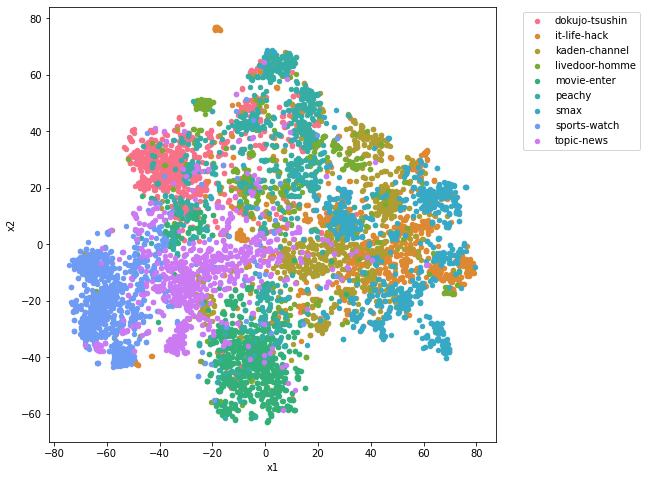

In [21]:
corpus_reader.visualize_vectors()

In [22]:
corpus_reader.save()

100%|█████████████████████████████████████| 7365/7365 [00:03<00:00, 2406.32it/s]
